#### LIBRARIES USED

In [8]:
import numba
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from matplotlib import colors
from IPython import display
import time
from scipy.signal import convolve2d

#### SEGREGATION MODEL

The model describes the evolution of an population in a city, that is divided in Q blocks with H sites each. Each site can be occupied by 0 or 1 agent. The agents move around the city according to some rule, for example, maximize its utility.

#### FUNCTIONS'S DEFINITIONS

In [9]:
vacancy_value = 0
altruist_value = 1
egoist_value = 2

In [10]:
def plot_grid(agents, n):
    # creates a discrete colormap
    vacancy = np.array([147.0/255, 148.0/255, 150.0/255])     # grey
    yellow =  np.array([247.0/255, 247.0/255, 0.0/255])       # yellow
    red = np.array([255.0/255, 0.0/255, 0.0/255])             # red
    cmap = colors.ListedColormap([vacancy, yellow, red])
    # determines the limits of each color:
    bounds = [vacancy_value, altruist_value, egoist_value, egoist_value + 1]            
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(agents, cmap=cmap, norm=norm)

    # draws gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, agents.shape[1], n));
    ax.set_yticks(np.arange(-0.5, agents.shape[0], n));

    plt.show()

In [11]:
def create_city(n, q, altruist_densiy, egoist_density):
    vacancy_array = np.array([[-1,-1,-1]])
    agent_array   = np.array([[-1,-1,-1, -1]])
    density_array = np.full(q*q,0.0)
    city_side = n*q
    
    # creates a city without borders, that will be a toroidal grid
    city = np.full((city_side,city_side), vacancy_value)
    altruists = 0
    egoists = 0
    
    for code in range(q*q):
        block_x = int((code%q) * n)
        block_y = int(np.floor(code/q) * n)
        
        agents_in_block = 0.0
        
        for di in range(0,n):
            for dj in range(0,n):
                i = block_y + di
                j = block_x + dj
                rnd = np.random.random()
                if rnd <= altruist_densiy:
                    city[i,j] = altruist_value
                    agents_in_block += 1
                    altruists += 1
                    agent_array = np.append(agent_array, [[code, i, j, altruist_value]], axis=0)
                elif altruist_densiy < rnd <= altruist_densiy + egoist_density:
                    city[i,j] = egoist_value
                    agents_in_block += 1
                    egoists += 1
                    agent_array = np.append(agent_array, [[code, i, j, egoist_value]], axis=0)
                else:
                    vacancy_array = np.append(vacancy_array, [[code, i, j]], axis=0)
        
        block_density = agents_in_block/(n*n)
        density_array[code] = block_density 

    vacancy_array = np.delete(vacancy_array, 0,0)
    agent_array = np.delete(agent_array, 0,0)
    
    return city, vacancy_array, agent_array, density_array, altruists, egoists

In [12]:
def utility_function(pho):
    if(pho <= 0.5):
        utility = 2*pho
    else:
        utility = 2*(1 - pho)
    
    return utility

In [13]:
def detect_utility(agent_array, num, density_array):
    #check agent utility
    code = agent_array[num,0]
    pho = density_array[code]
    utility = utility_function(pho)

    return utility

In [14]:
def detect_city_utility(n, density_array): 
    #check city utility
    city_utility = 0.0

    for pho in density_array:
        city_utility += utility_function(pho)*pho*n*n
    
    return city_utility

In [15]:
def simulation_step(n, city, vacancy_array, agent_array, density_array, city_utility):
    #we choose an agent and a vancant site in another block, it moves if its utility function increases.
    change = False
    rndV = np.random.randint(0, len(vacancy_array))
    rndA = np.random.randint(0, len(agent_array))
    codeV = vacancy_array[rndV,0] 
    codeA = agent_array[rndA,0]
    phoV = density_array[codeV]
    phoA = density_array[codeA]
    
    iV, jV = vacancy_array[rndV,1:3]
    iA, jA = agent_array[rndA,1:3]
    
    #altruist movement condition
    if(agent_array[rndA,3] == altruist_value):
        density_array[codeV] += 1/(n*n)
        density_array[codeA] -= 1/(n*n)
        
        new_city_utility = detect_city_utility(n, density_array)
        
        density_array[codeV] = phoV
        density_array[codeA] = phoA
        
        if(new_city_utility > city_utility):
            change = True
    
    #egoist movement condition
    elif(agent_array[rndA,3] == egoist_value):
        agent_utility = utility_function(phoA)
        new_agent_utility = utility_function(phoV + 1/(n*n))
        
        if(new_agent_utility > agent_utility):
            change = True
    
    
    if(change):
        #update system
        
        #update vacancy and agent arrays
        vacancy_array[rndV] = [codeA,iA,jA]
        agent_array[rndA,0:3] = [codeV,iV,jV]

        #update city grid
        city[iA,jA] = vacancy_value
        city[iV,jV] = agent_array[rndA,3]
        
        #update density array
        density_array[codeV] += 1/(n*n)
        density_array[codeA] -= 1/(n*n)
        
        #update city_utility
        city_utility = detect_city_utility(n, density_array)
    
    return city, vacancy_array, agent_array, density_array, city_utility

#### MODEL TESTING

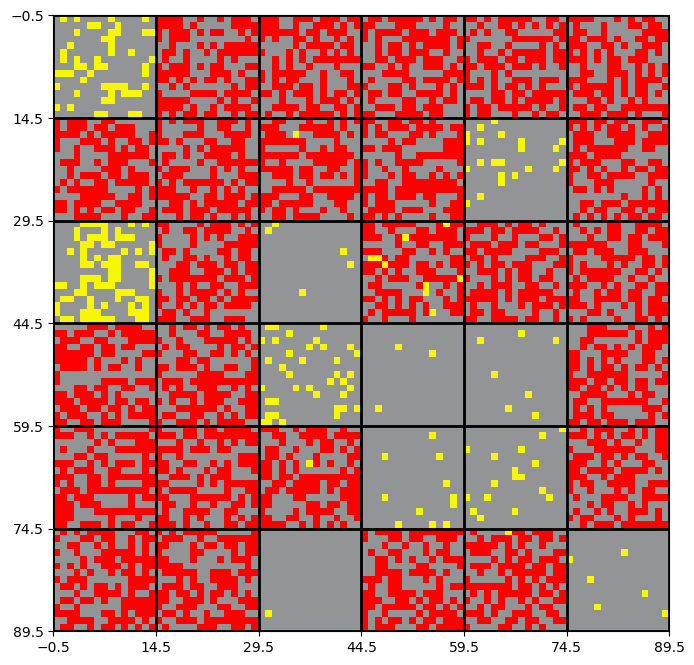

In [17]:
n = 15
q = 6
agent_density = 0.4
altruist_density = 0.03
egoist_density = agent_density - altruist_density

city, vacancy_array, agent_array, density_array, altruists, egoists = create_city(n, q, altruist_density, egoist_density)

city_utility = detect_city_utility(n, density_array)

steps = 100000
passo = steps/50
for a in range(steps):
    city, vacancy_array, agent_array, density_array, city_utility = simulation_step(n, city, vacancy_array, agent_array, density_array, city_utility)
    
    if(a%passo == 0):
        plot_grid(city, n)
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)